# Final Report
By Daniel Fraser and Peter Laskai

# 1. Describe project goals and why it is interesting 
We plan to use this data to predict which languages are being used, what they’re being used for (commercial, fun, etc). The data behind Github is fascinating because it is one the most used version control software out there and allows the public to see the trend of languages throughout the years and see what type of projects people create, and how they collaborate with one another.

# 2. Describe data collection/source of data, data format, data preprocessing
This dataset gives us info on what languages are used, its files (including their contents) and their size along with info on commits. We will use a combination of the data from bigquery along with using Github’s official api using javascript. Bigquery’s data is listed as tables, while the api will give us info in the form of an API response as json file. With bigquery, we have to eliminate rows that have a date before the creation of github (which is about 0.04% (10 million) which is most likely an error from importing data to bigQuery) of the total rows. With the api, we eliminate some of the redundant information such as owner of repo (since unless you’re searching, you get the repo based off the username).

One of our data collection source was Octokit’s [rest.js](https://github.com/octokit/rest.js), a JavaScript based API scraper tool adopted by the GitHub team. From there we could access a large amount github data arranging from, user info, repository details, gists, issues, and pull requests from 24 million users.This is an example of a “query” using rest.js:
```
//This specific function gets all the info of JavaFXMusicLibrary repository from user PrL327
octokit.repos.get({
  owner: 'prl327',
  repo: 'JavaFXMusicLibrary'
}).then(({data}) => {
  console.log(data);
}); 
```
 Right now since we can only evaluate data that is public like public organizations and public repos, we had to put a safeguard in which we return 0, which in the end we filter out. We also have to worry about hitting the query limit for the api which is 1000 queries a hour. We actually combined the use of BigQuery and Rest.js in one example. We had a csv file which contained two columns for username and repository, with about 10,000 rows. to easily process that csv file through our query we needed to convert it to a JSON for easy parsing. For this we used csv a node library and it's resepective functions to do the conversion, it produce an object like such:
 ```
 {
     "User": "prl327",
     "Repository": "JavaFXMusicLibrary"
 }
 ```
 And so on for 10,000 more user/repo combinations.

# 3. Describe contents of data in detail (write code to analyse and visualize it) 
For our first plot, we gathered data using the github api since bigquery doesn't have any tables with information on contributors. The next four visualizations are from bigquery using it's language table that gives us information on languages used and total bytes of each language for each repository.

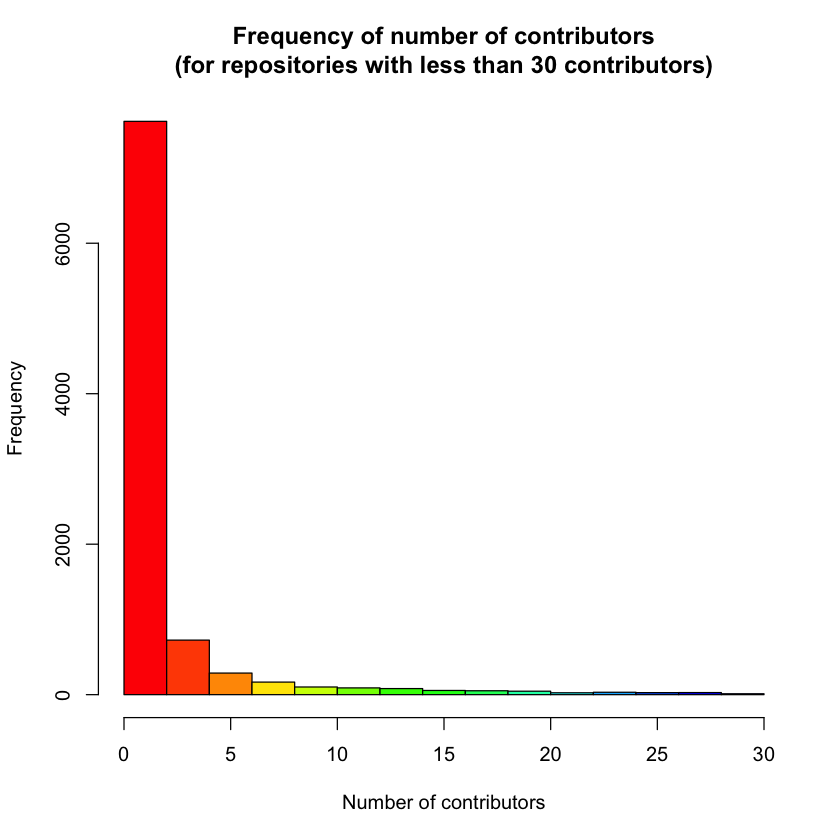

In [2]:
repos <- read.csv("repos.csv", header = TRUE)
hist(repos$contributors[repos$contributors > 0 & repos$contributors < 30], 10,
     col = rainbow(20), xlab = "Number of contributors", main = "Frequency of number of contributors\n(for repositories with less than 30 contributors)")

# 4. Describe possible applications of this data, Including your ideas for the next phase
An application for this data is seeing what type of programs use more storage than others allowing a system administrator to give certain users more storage based on their favorite language. One interesting application will be seeing which libraries are commonly used (also see what type of libraries are most commonly used like reading json/csv files, machine learning, etc.) and can go a step further and seeing what are the top 10 libraries for each language for each year. We will be using this data to predict which languages will be expected to be used the most in 2018 and 2019. Since we also get information like commits, we can use this data to see average commits, average time between commits, and see average lifetime of a repository. We are also able to see contents of every file in any public repository, so we can use the contents to teach a machine learning algorithm to tell the difference between python and javascript or between java and c++, etc.

# Machine Learning - Language Interpreting

We are also able to see contents of every file in any public repository, so we can use the contents to teach a machine learning algorithm to tell the difference between python and javascript or between java and c++, etc. For this process we went through we gathered the data from the Github's dataset on Google where we looked at both their `files` table and `content` table. We had to `JOIN` both tables based on file ids so we could get filenames and content together. From there we decided for our machine learning algorithm we would use Decision Trees to train our machine in recognizing the 8 most popular langauges.

# Conclusion

## Acknowledgments
* [Github API (js)](https://github.com/octokit/rest.js)
* [csv (js)](https://www.npmjs.com/package/csv)
* [jsonfile (js)](https://www.npmjs.com/package/jsonfile)
* [BigQuery](https://bigquery.cloud.google.com)